In [1]:
from pykrx import stock
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform
import datetime
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
stock_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
stock_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))

C:\Users\ghdak\AppData\Local\Temp/ipykernel_20228/2926285922.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_20228/2926285922.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_20228/2926285922.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

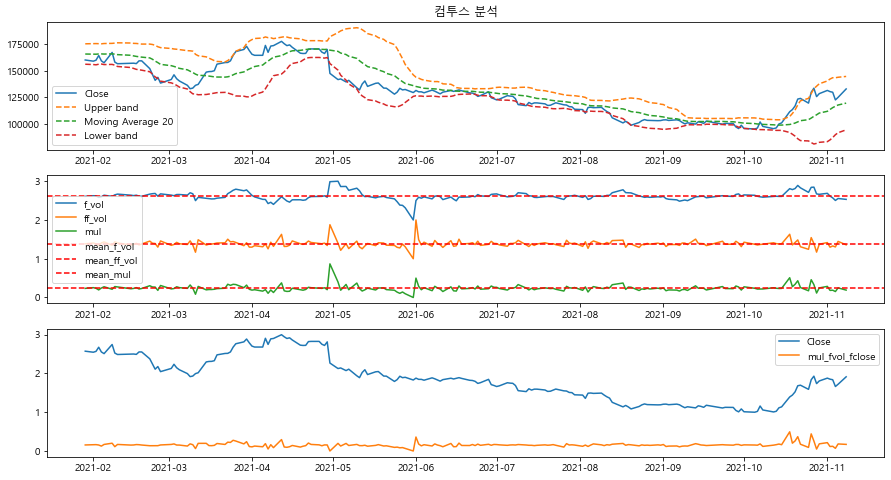

In [52]:
name = '컴투스'
today = datetime.datetime.today()
month_ago = str(today.year) + str(today.month-1) + str(today.day)
month_ago2 = str(today.year) + str(today.month-2) + str(today.day)
today = str(today.year) + str(today.month) + str(today.day)
fromdate = str(20210101)
todate = today

ticker = stock_list.loc[stock_list['종목명']==name, '종목코드']
df = stock.get_market_ohlcv_by_date(fromdate=fromdate, todate=todate, ticker=ticker)


df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
df = df[19:] # 20일 이동평균을 구했기 때문에 20번째 행부터 값이 들어가 있음
df['volatility'] = (df['upper'] - df['lower'])/2

df1 = df.copy().loc[:,('Close','ma20','volatility')]
df1.insert(0, column='f_close', value=0)
df1.insert(0, column='f_ma20', value=0)
df1.insert(0, column='f_vol', value=0)
df1.insert(0, column='ff_vol', value=0)

for i in range(1, len(df1)):
    df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
    df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
    df1['f_close'][i] = df['Close'][i] - df['Close'][i-1]
for i in range(1, len(df1)):
    df1['ff_vol'][i] = df1['f_vol'][i] - df1['f_vol'][i-1]


scaler = MinMaxScaler()
df2 = df1.copy()
df2[:] = scaler.fit_transform(df2[:])


fig, ax = plt.subplots(3,1,figsize=(15,8))

ax[0].plot(df.index, df['Close'], label='Close')
ax[0].plot(df.index, df['upper'], linestyle='dashed', label='Upper band')
ax[0].plot(df.index, df['ma20'], linestyle='dashed', label='Moving Average 20')
ax[0].plot(df.index, df['lower'], linestyle='dashed', label='Lower band')
ax[0].legend(loc='best');
ax[0].set_title(f'{name} 분석')

ax[1].plot(df2['f_vol']+2)
ax[1].plot(df2['ff_vol']+1) 
ax[1].plot(df2['f_vol']*df2['ff_vol']) 
ax[1].axhline(df2['f_vol'].mean()+2, color='red', linestyle='--')
ax[1].axhline(df2['ff_vol'].mean()+1, color='red', linestyle='--')
ax[1].axhline((df2['ff_vol']*df2['f_vol']).mean(), color='red', linestyle='--')
ax[1].legend([ 'f_vol', 'ff_vol', 'mul', 'mean_f_vol', 'mean_ff_vol', 'mean_mul',])

ax[2].plot(df2['Close']*2 + 1)
ax[2].plot(df2['f_close'] * df2['ff_vol'] * df2['f_vol'])

ax[2].legend(['Close', 'mul_fvol_fclose'])
plt.show()